# Lab 1 - Used Cars in the USA
#### By: David Wei, Sophia Wu, Dhruba Dey, Queena Wang

### Business Understanding:
As a team, we decided to work on a dataset which can easily be understood from our common life experience without needing specific domain knowledge such as finance, marketing and so forth. Secondly, we wanted to dabble ourselves with a dataset, that we had not previously exposed to, such as Real Estate, Life expectancy, etc. Off course, we must meet the project guidelines of 30,000 rows and 10 features, which in fact prompted us to look for somewhat large dataset with multiple features so that can effectively cull right set of features having numerical, boolean and categorical values. In addition, working with a large dataset would provide us with the experience that we have not acquired yet. This thought process of data selection has led us to grab “Used Car Dataset”, which has 3 million rows and 66 features. 
<br>
<br>
We wanted to build 3 different types of models on this dataset. First is Regression, second binary classification using Logistic Regression and third multiple classification using either K-nearest or K-means Random Forest depending on the best fit. We picked “Price” as the response feature for Regression model because it has numerical value and a pivotal point in the used car purchase. For Logistic Regression, we opted for “has_accidents” as the response variable because it has boolean values and an interesting point to observe whether we can effectively classify the used car with accidents. Finally, we used “body_type” as the target variable for multi-value classification. “Body_type” has 9 attributes which we believed a good candidate for multi-class classification. 
<br>
<br>
We applied first our domain knowledge, which is our collective experience of used car buying, to mine features that we thought would be relevant for making decision on a used car purchase. That helped us reduce the numbers of features from 66 to 40.  Then we took a close at each feature and tried to eliminate as many as possibleto keep the data size manageable so that we could handle data wrangling and model building, to be performed in the next phase, with the computing resources available to us. Also, we provided the justification as to why a feature was removed from the list of 40. However, we were cautious about categorical variable because itwould spawn to multiple variables after encoding. That is the key reason why we restricted the categorical feature to one. In the final dataset, we have 12 variables comprising 9 numerical, 2 boolean and 1 categorical. By the way, removing the missing values after sub-setting the data set to the intended features, we reduced the numbers of rows close to 700K from 3M. And we would also conduct PCA and Regularizations for dimensionality reduction. Based on the analysis and understanding of the data, we believed we selected the right set of data for the purpose of this project. 


In [ ]:
#!pip install missingno
#!pip install plotnine

In [39]:
#importing libraries and reading in file
import pandas as pd
import numpy as np
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine.data import economics
from plotnine import ggplot, aes, geom_line
warnings.filterwarnings('ignore') #ignoring warnings

from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean

In [2]:
# NOTE: need to change file per user
df_raw = pd.read_csv(r'C:\Data\used_cars_data.csv')
#df_raw = pd.read_csv('https://raw.githubusercontent.com/chee154/ml-Py-used_cars/main/data/kaggle_used_cars_data.csv')
#df_raw = pd.read_csv('C:/Users/Queen/Desktop/Pandas_Demo/kaggle_used_cars_data.csv')

In [4]:
df_raw.head(5)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [5]:
print("Total # of Records: " + str(df_raw.shape[0]))
print("Total # of Columns: " + str(df_raw.shape[1]))

Total # of Records: 3000040
Total # of Columns: 66


### Data Meaning Type

#### Domain based Attribute Reduction
Before we do a deep dive into the types of our data, we will first look into reducing it from a  The total dataset has 66 attributes After a quick observation of the column headers, we can deduce that not all columns will be necessary for our analysis. Reasons for removing them below:

In [6]:
#subsetting columns by referencing the column indexes
df_cln_1 = df_raw.iloc[:, np.r_[0,5,7:11,13:17,18:21,22:30,32,35:38,42:50,51,55:57,61:63,64:66]]
print(df_cln_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 40 columns):
 #   Column                Dtype  
---  ------                -----  
 0   vin                   object 
 1   body_type             object 
 2   city                  object 
 3   city_fuel_economy     float64
 4   combine_fuel_economy  float64
 5   daysonmarket          int64  
 6   engine_cylinders      object 
 7   engine_displacement   float64
 8   engine_type           object 
 9   exterior_color        object 
 10  frame_damaged         object 
 11  franchise_dealer      bool   
 12  franchise_make        object 
 13  fuel_tank_volume      object 
 14  fuel_type             object 
 15  has_accidents         object 
 16  height                object 
 17  highway_fuel_economy  float64
 18  horsepower            float64
 19  interior_color        object 
 20  isCab                 object 
 21  is_new                bool   
 22  length                object 
 23  listed_

### Data Quality

In [ ]:
msno.matrix(df_cln_1)

After doing a quick profiling on some our identified columsn, we can see that both engine_cylinders and engine_type are the same. Additionally, we also found that the prefixes and suffixes attached to them are descriptive of it and thus not a continuous value. 

In [7]:
# removing city_fuel_economy since a quick vizualition of our dataset shows that ALL values are empty
df_cln_1 = df_cln_1.drop(columns='combine_fuel_economy')
print(df_cln_1.shape[1])

39


We also found that 'engine_cylinders','engine_type' contains the same data in two separate columns, so we first test if this condition is true and if it is, we will remove one.

In [8]:
#observing if 'engine_cylinders','engine_type' is the same data
if df_cln_1['engine_cylinders'].equals(df_cln_1['engine_type']) == True:
    df_cln_1 = df_cln_1.drop(columns='engine_cylinders')
    print(df_cln_1.shape[1])

38


We also found additional columns that were simply descriptions of another columns, for example. The 'wheel_system_display' attribute is simply a longer, more descriptive version of the 'wheel_system' attribute ("Front-Wheel Drive" vs "FWD"). For columns that follow this trend, we will remove the descriptive column from our dataset. 

In [9]:
print(df_cln_1[['wheel_system']])
print(df_cln_1[['wheel_system_display']])
df_cln_1 = df_cln_1.drop(columns='wheel_system_display')
print(df_cln_1.shape[1])

        wheel_system
0                FWD
1                AWD
2                AWD
3                AWD
4                AWD
...              ...
3000035          FWD
3000036          FWD
3000037          FWD
3000038          AWD
3000039          FWD

[3000040 rows x 1 columns]
        wheel_system_display
0          Front-Wheel Drive
1            All-Wheel Drive
2            All-Wheel Drive
3            All-Wheel Drive
4            All-Wheel Drive
...                      ...
3000035    Front-Wheel Drive
3000036    Front-Wheel Drive
3000037    Front-Wheel Drive
3000038      All-Wheel Drive
3000039    Front-Wheel Drive

[3000040 rows x 1 columns]
37


We also discussed that 'interior_color' attribute has 45,726 distinct color values and so due to the sheer volume and complexity (# of levels in this attribute). We also decided to remove it from our dataset since it is unrealistic for the type of modeling we are doing and would effect the overall performance of our model.

In [ ]:
#note this plot takes forever to run
#(ggplot(df_cln_1)+aes(x="interior_color", y="price")+geom_line())

In [10]:
print(df_cln_1['interior_color'].nunique())

df_cln_1 = df_cln_1.drop(columns='interior_color')
print(df_cln_1.shape[1])

45726
36


Another attribute we found that could be removed as the "listed_date" attribute. Since there was no other 'datetype' attributes available in our dataset, we didn't really see a point with keeping it as there was no other data reference to use it with. Additionally, the attribute 'daysonmarket' already pre-aggregated the number of days it took to sell a vehicle, which the listed date would've been used for otherwise. Because of this, we will also remove it from our dataframe.

In [11]:
df_cln_1 = df_cln_1.drop(columns='listed_date')
print(df_cln_1.shape[1])

35


At this point, we decided to take a break from subsetting our data and take a look at the amount of missing values in the current dataframe. Our intention in mind was to see what the data looked like after it was cleaned to further proceed reducing the amount of attributes we had.

### Data Cleaning - Duplicates, Missing Data,  Nulls
Now that our datatypes have been adjusted. We will work on cleaning up any empty data in our dataset. To begin, we will check if any of the VINs have duplicates in the dataset, since this the VIN is unique to a car we are expecting there shouldn't be, but in cases there is, we will remove it.

In [12]:
df_cln_1[df_cln_1.duplicated(['vin'], keep=False)].sort_values('vin')

,vin,body_type,city,city_fuel_economy,daysonmarket,engine_displacement,engine_type,exterior_color,frame_damaged,franchise_dealer,...,owner_count,power,price,salvage,seller_rating,torque,transmission,wheel_system,width,year
2000032,1C3CCCBG4FN686074,Sedan,Deer Park,19.0,530,3600.0,V6,Blue,False,False,...,1.0,"295 hp @ 6,350 RPM",13488.0,False,4.453125,"262 lb-ft @ 4,250 RPM",A,FWD,73.6 in,2015
2000052,1C3CCCBG4FN686074,Sedan,Deer Park,19.0,530,3600.0,V6,Blue,False,False,...,1.0,"295 hp @ 6,350 RPM",13488.0,False,4.453125,"262 lb-ft @ 4,250 RPM",A,FWD,73.6 in,2015
2000043,1C6RR7FT5ES405345,Pickup Truck,Bonners Ferry,NaN,49,5700.0,V8,GRAY,False,False,...,1.0,"395 hp @ 5,600 RPM",20480.0,False,4.750000,"407 lb-ft @ 3,950 RPM",NaN,4WD,79.4 in,2014
2000023,1C6RR7FT5ES405345,Pickup Truck,Bonners Ferry,NaN,49,5700.0,V8,GRAY,False,False,...,1.0,"395 hp @ 5,600 RPM",20480.0,False,4.750000,"407 lb-ft @ 3,950 RPM",NaN,4WD,79.4 in,2014
1000038,1FA6P8TH0J5179933,Coupe,Groveport,21.0,7,2300.0,I4,Lightning Blue Metallic,False,False,...,1.0,"310 hp @ 5,500 RPM",24000.0,False,4.211765,"350 lb-ft @ 3,000 RPM",A,RWD,81.9 in,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000030,7FART6H88LE013181,SUV / Crossover,Westerville,40.0,28,2000.0,I4 Hybrid,Platinum White Pearl,NaN,False,...,NaN,"212 hp @ 6,200 RPM",33970.0,NaN,4.377049,NaN,CVT,AWD,73 in,2020
2000037,JTEBU5JR5K5687002,SUV / Crossover,Airway Heights,17.0,20,4000.0,V6,WHITE,False,False,...,NaN,"270 hp @ 5,600 RPM",44995.0,False,3.964286,"278 lb-ft @ 4,400 RPM",A,4WD,75.8 in,2019
2000057,JTEBU5JR5K5687002,SUV / Crossover,Airway Heights,17.0,20,4000.0,V6,WHITE,False,False,...,NaN,"270 hp @ 5,600 RPM",44995.0,False,3.964286,"278 lb-ft @ 4,400 RPM",A,4WD,75.8 in,2019
2000044,JTNK4RBE3K3044291,NaN,Colville,NaN,33,NaN,I4,BLACK,False,True,...,1.0,NaN,21000.0,False,4.583333,NaN,A,NaN,NaN,2019


We can see that that there are duplicates even though the 'vin' should be specific and distinct to each car. There is a total of 80 records that contain duplicates. We will then remove these duplicates while keeping the 'first' record so that one copy of the duplcites will remain. We can see that after we cleaned these duplicates, our total # of records drop from 3,000,040 to 3,000,000. 

In [13]:
print(df_cln_1.shape[0])

3000040


In [14]:
df_cln_1 = df_cln_1.drop_duplicates(subset=['vin'], keep='first')
print("# of records after removing duplicates: "+str(df_cln_1.shape[0]))

# of records after removing duplicates: 3000000


After we have cleaned our duplicates. A quick visualization of our data shows that almost every column has empty values. We will focus on analyzing those that have a large amount of empty data (ex. Frame_Damaged, has_accidents, isCab, etc.)

In [ ]:
#visualizatin of our data BEFORE removing all rows with missing data
msno.matrix(df_cln_1)

In [15]:
# remove the missing values
df_cln_2 = df_cln_1.dropna()
print(len(df_cln_2))

697989


In [16]:
# checking the row counts of columns to see the missing rows
df_cln_2.count()

vin                     697989
body_type               697989
city                    697989
city_fuel_economy       697989
daysonmarket            697989
engine_displacement     697989
engine_type             697989
exterior_color          697989
frame_damaged           697989
franchise_dealer        697989
franchise_make          697989
fuel_tank_volume        697989
fuel_type               697989
has_accidents           697989
height                  697989
highway_fuel_economy    697989
horsepower              697989
isCab                   697989
is_new                  697989
length                  697989
listing_color           697989
make_name               697989
maximum_seating         697989
mileage                 697989
model_name              697989
owner_count             697989
power                   697989
price                   697989
salvage                 697989
seller_rating           697989
torque                  697989
transmission            697989
wheel_sy

In [ ]:
#visualizatin of our data AFTER removing all rows with missing data
msno.matrix(df_cln_2)

We decided that since our original dataset was large (10gb with 3million records), that instead of imputing data based on the mean or other statistical types, that deleting all records with empty values still returned 700,000 total records that not only provides plenty of data leftover, but also raw data that isn't imputed. 

### Data Cleaning - Datatypes
Obviously at this point we need to convert a few of our data columns to the appropriate data type by removing parts of the value string that we do not need such as "gal" in the ful_tank_volume

In [17]:
#finding all unique values per column to see what values we need to clean
columns_that_need_cleaning = ['engine_type','exterior_color','frame_damaged','franchise_dealer','franchise_make','fuel_tank_volume','fuel_type','has_accidents','height','isCab','is_new','length','listing_color','make_name','maximum_seating','model_name','power','salvage','torque','transmission','wheel_system','width']
for col in columns_that_need_cleaning:
        print(df_cln_2[col].unique())

['I4' 'V6' 'V8' 'H4' 'I6' 'V8 Flex Fuel Vehicle' 'V6 Flex Fuel Vehicle'
 'I5' 'I4 Diesel' 'I4 Flex Fuel Vehicle' 'I4 Hybrid' 'V6 Diesel'
 'I6 Diesel' 'I3' 'W12 Flex Fuel Vehicle' 'V6 Biodiesel' 'V12' 'V10' 'W12'
 'H6' 'H4 Hybrid' 'V6 Hybrid' 'I4 Compressed Natural Gas' 'W16' 'R2'
 'I6 Hybrid' 'V6 Compressed Natural Gas']
['Silver Ice Metallic' 'Black' 'Diamond Black Crystal Pearlcoat' ...
 'VICTORIA BLACK' 'Modern S' 'Cosmic']
[False True]
[ True]
['Chevrolet' 'Jeep' 'Cadillac' 'Chrysler' 'Dodge' 'Kia' 'RAM' 'Mazda'
 'Audi' 'Hyundai' 'Ford' 'Toyota' 'Lincoln' 'Volvo' 'GMC' 'Volkswagen'
 'BMW' 'Lexus' 'Buick' 'Subaru' 'Scion' 'Honda' 'Acura' 'Nissan'
 'INFINITI' 'Porsche' 'Rolls-Royce' 'Lamborghini' 'Bentley'
 'Mercedes-Benz' 'Jaguar' 'Land Rover' 'Maserati' 'Ferrari' 'MINI' 'FIAT'
 'Alfa Romeo' 'Mitsubishi' 'Aston Martin' 'Lotus' 'McLaren' 'SRT'
 'Genesis' 'smart' 'Shelby' 'Pagani']
['15.8 gal' '17.4 gal' '19.4 gal' '22 gal' '24.6 gal' '13.5 gal'
 '13.2 gal' '15.9 gal' '12.7 gal' '22.5

['SILVER' 'BLACK' 'RED' 'WHITE' 'UNKNOWN' 'BLUE' 'GRAY' 'BROWN' 'YELLOW'
 'ORANGE' 'GREEN' 'PURPLE' 'TEAL' 'GOLD' 'PINK']
['Chevrolet' 'Lexus' 'Jeep' 'Hyundai' 'Cadillac' 'Chrysler' 'Dodge'
 'Nissan' 'Honda' 'Mercedes-Benz' 'Kia' 'Ford' 'Lincoln' 'Subaru' 'BMW'
 'Audi' 'Volkswagen' 'Jaguar' 'Mazda' 'GMC' 'Toyota' 'Acura' 'INFINITI'
 'RAM' 'FIAT' 'Volvo' 'Buick' 'Land Rover' 'Mitsubishi' 'Genesis'
 'Maserati' 'Saab' 'Bentley' 'MINI' 'Alfa Romeo' 'Porsche' 'Lotus'
 'Rolls-Royce' 'Lamborghini' 'Scion' 'Saturn' 'Ferrari' 'Pontiac'
 'Mercury' 'Suzuki' 'Aston Martin' 'Oldsmobile' 'McLaren' 'smart' 'Isuzu'
 'Plymouth' 'Hummer' 'SRT' 'Bugatti']
['5 seats' '4 seats' '8 seats' '7 seats' '6 seats' '2 seats' '3 seats'
 '15 seats' '12 seats' '9 seats' '--' '10 seats']
['Malibu' 'RC 350' 'Traverse' 'Grand Cherokee' 'Compass' 'Veloster' 'XT4'
 '200' 'Renegade' 'Wrangler Unlimited' 'Durango' 'Charger'
 'Silverado 1500' 'Rogue' 'Civic' 'RX 350' 'GLC-Class' 'Optima' 'Explorer'
 'Navigator' 'Outback' '4 

[False True]
['184 lb-ft @ 2,500 RPM' '280 lb-ft @ 4,800 RPM' '266 lb-ft @ 2,800 RPM'
 ... '267 lb-ft @ 4,800 RPM' '220 lb-ft @ 3,800 RPM'
 '177 lb-ft @ 4,500 RPM']
['A' 'M' 'CVT' 'Dual Clutch']
['FWD' 'AWD' '4WD' 'RWD' '4X2']
['73 in' '81.5 in' '78.6 in' '78.5 in' '84.8 in' '71.4 in' '70.9 in'
 '83.5 in' '73.6 in' '79.6 in' '82.8 in' '85.5 in' '73.8 in' '75 in'
 '80 in' '70.8 in' '74.6 in' '82.5 in' '73.2 in' '90.2 in' '93.8 in'
 '81.3 in' '71.8 in' '84.3 in' '80.5 in' '72.8 in' '78.1 in' '90.4 in'
 '72.4 in' '74.7 in' '69.9 in' '73.7 in' '71.2 in' '83.9 in' '77.2 in'
 '76.7 in' '74.4 in' '75.2 in' '81.9 in' '81.2 in' '85.6 in' '69 in'
 '88.5 in' '72 in' '77.5 in' '79.5 in' '72.3 in' '78.9 in' '73.4 in'
 '79.3 in' '69.2 in' '72.9 in' '72.2 in' '80.3 in' '75.5 in' '70.1 in'
 '77.7 in' '71.1 in' '71.7 in' '80.8 in' '85.8 in' '72.6 in' '72.5 in'
 '67.8 in' '81.8 in' '89.3 in' '91.5 in' '82.6 in' '96.8 in' '79.4 in'
 '79 in' '68.5 in' '83.7 in' '87.5 in' '74 in' '70 in' '70.5 in' '74.9 in

In [18]:
#finding all unique values per column to see what values we need to clean
columns_that_need_cleaning_2 = ['fuel_tank_volume','height','length','maximum_seating','width',]
for col in columns_that_need_cleaning_2:
        print(df_cln_2[col].unique())

['15.8 gal' '17.4 gal' '19.4 gal' '22 gal' '24.6 gal' '13.5 gal'
 '13.2 gal' '15.9 gal' '12.7 gal' '22.5 gal' '21.5 gal' '18.5 gal'
 '26 gal' '12.4 gal' '19.2 gal' '18.6 gal' '23.2 gal' '24 gal' '16.4 gal'
 '13.7 gal' '19 gal' '14.5 gal' '14 gal' '18 gal' '16.9 gal' '21 gal'
 '19.5 gal' '31 gal' '18.8 gal' '16 gal' '16.6 gal' '21.7 gal' '20 gal'
 '15.3 gal' '22.2 gal' '17.2 gal' '21.1 gal' '16.1 gal' '13 gal'
 '23.8 gal' '17 gal' '15.1 gal' '19.8 gal' '23 gal' '20.5 gal' '11.9 gal'
 '14.2 gal' '14.3 gal' '14.8 gal' '17.7 gal' '16.5 gal' '17.8 gal'
 '15.6 gal' '17.1 gal' '15.5 gal' '10.6 gal' '15.7 gal' '18.1 gal'
 '20.1 gal' '12.8 gal' '20.3 gal' '21.6 gal' '21.9 gal' '11.4 gal'
 '36 gal' '16.8 gal' '15.4 gal' '16.3 gal' '28.3 gal' '17.9 gal'
 '27.7 gal' '13.6 gal' '17.5 gal' '28 gal' '27 gal' '22.4 gal' '20.6 gal'
 '26.4 gal' '11.6 gal' '11.8 gal' '12 gal' '19.3 gal' '13.1 gal'
 '10.8 gal' '14.9 gal' '19.1 gal' '12.1 gal' '27.3 gal' '38 gal'
 '11.3 gal' '32 gal' '10 gal' '23.3 gal' '2

 '66.8 in' '65.3 in' '63.7 in' '81.6 in' '62.6 in']


Regarding fuel_tank_volume and maximum_seating, we can see that there appears to be a pattern in the suffixes, "gal" and "seats" accordingly. We will now remove them and then convert all values to numeric.

In [19]:
#removing unecesary string values in columns
#then cleaning up any values that contain '--' and replacing it with NaN
#Lastly, converting the value first to a string type and then to a float type

df_cln_2['fuel_tank_volume']=df_cln_2['fuel_tank_volume'].astype(str).str.replace(' gal', '').replace('--',np.NaN).astype(float)
df_cln_2['height']=df_cln_2['height'].astype(str).str.replace(' in', '').replace('--',np.NaN).astype(float)
df_cln_2['length']=df_cln_2['height'].astype(str).str.replace(' in', '').replace('--',np.NaN).astype(float)
df_cln_2['maximum_seating']=df_cln_2['maximum_seating'].astype(str).str.replace(' seats', '').replace('--',np.NaN).astype(float)
df_cln_2['width']=df_cln_2['width'].astype(str).str.replace(' in', '').replace('--',np.NaN).astype(float)

In [20]:
#doing a quick profile on the subsetted columns
print(df_cln_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697989 entries, 38 to 3000039
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vin                   697989 non-null  object 
 1   body_type             697989 non-null  object 
 2   city                  697989 non-null  object 
 3   city_fuel_economy     697989 non-null  float64
 4   daysonmarket          697989 non-null  int64  
 5   engine_displacement   697989 non-null  float64
 6   engine_type           697989 non-null  object 
 7   exterior_color        697989 non-null  object 
 8   frame_damaged         697989 non-null  object 
 9   franchise_dealer      697989 non-null  bool   
 10  franchise_make        697989 non-null  object 
 11  fuel_tank_volume      697819 non-null  float64
 12  fuel_type             697989 non-null  object 
 13  has_accidents         697989 non-null  object 
 14  height                697882 non-null  float64
 15

We can now see that all of our column values have been adjusted to the correct datatypes. We will next proceed with cleaning up the remainder of our data attributes. A quick count on our datatypes shows us that we still have 19 categorical values, 14 numerical types and 2 booleans (true/false) left to work wikth. Since our ultimate goal is doing a regression and one classification model, we will next work on trimming down our 'object' categorical data types.

In [21]:
#count of datatypes in current dataframe.
print(df_cln_2.dtypes.value_counts())
print("---------------------------------------------")
#showing only the object type columns
print(df_cln_2.select_dtypes(include='object').columns)

object     18
float64    13
int64       2
bool        2
dtype: int64
---------------------------------------------
Index(['vin', 'body_type', 'city', 'engine_type', 'exterior_color',
       'frame_damaged', 'franchise_make', 'fuel_type', 'has_accidents',
       'isCab', 'listing_color', 'make_name', 'model_name', 'power', 'salvage',
       'torque', 'transmission', 'wheel_system'],
      dtype='object')


After the team decided to choose 'body_type' as main the main classification term. We decided to create a final dataframe with only the attributes we found useful for our model which excludes:
- **'vin'**: acts as primary index but not useful for modeling
<br>
- **'city'**: no model of ours will require geographic features, also since there is not state or zip attributes, it is ambiguous
<br>
- **'engine_type'**: use for EDA but 'horsepower' is the continous version of this attribute
<br>
- **'franchise_dealer'**: not useful for our model 
<br>
- **'franchise_make'**: same as 'make_name' which has too many levels as a categorical value and not necessary for our predictin model
<br>
- **'fuel_tank_volume'**: 
<br>
- **'fuel_type'**: 
<br>
- **'height'**: 
<br>
- **'isCab'**:
<br>
- **'listing_color'**: 
<br>
- **'make_name'**: 
<br>
- **'model_name'**: 
<br>
- **'power'**: 'horsepower' attribute will be used instead
<br>
- **'salvage'**: the value that is associated with depreciation number which is more of accounting. In real world, we pay what is the market value of the car.
<br>
- **'torque'**:  'horsepower' attribute will be used instead
<br>
- **'transmission'**: 
<br>
- **'wheel_system'**: 

In [22]:
df_cln_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697989 entries, 38 to 3000039
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vin                   697989 non-null  object 
 1   body_type             697989 non-null  object 
 2   city                  697989 non-null  object 
 3   city_fuel_economy     697989 non-null  float64
 4   daysonmarket          697989 non-null  int64  
 5   engine_displacement   697989 non-null  float64
 6   engine_type           697989 non-null  object 
 7   exterior_color        697989 non-null  object 
 8   frame_damaged         697989 non-null  object 
 9   franchise_dealer      697989 non-null  bool   
 10  franchise_make        697989 non-null  object 
 11  fuel_tank_volume      697819 non-null  float64
 12  fuel_type             697989 non-null  object 
 13  has_accidents         697989 non-null  object 
 14  height                697882 non-null  float64
 15

In [37]:
#creating final df for analysis
df_final = df_cln_2.iloc[:, np.r_[1,3:6,8,13,14:17,18:20,22:24,25,27,29,33:35]]
print(df_final.info())
print(df_final.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697989 entries, 38 to 3000039
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             697989 non-null  object 
 1   city_fuel_economy     697989 non-null  float64
 2   daysonmarket          697989 non-null  int64  
 3   engine_displacement   697989 non-null  float64
 4   frame_damaged         697989 non-null  object 
 5   has_accidents         697989 non-null  object 
 6   height                697882 non-null  float64
 7   highway_fuel_economy  697989 non-null  float64
 8   horsepower            697989 non-null  float64
 9   is_new                697989 non-null  bool   
 10  length                697882 non-null  float64
 11  maximum_seating       697884 non-null  float64
 12  mileage               697989 non-null  float64
 13  owner_count           697989 non-null  float64
 14  price                 697989 non-null  float64
 15

### Simple Statistics

##### Look at the final data, we have total 18 columns, their data types are: bool(1), float64(12), int64(2), object(3).

As our main goal is to predict car price and car type,in the simple statistics we need to find out the 5 most significant attributes that affect the car price, which's divided to below 5 steps:
1.Check the data range, mode, mean, median, variance and counts, etc
2.Check data normality
3.Correlation check
4.With the result from correlation checking,the 5 most significan attributes are horsepower(0.629),mileage(-0.43),highway_fuel_economy(-0.401), year(0.371) and engine_displacement(0.427)
The intresting thing is that seller_rating and owner_count don't show strong relationship to car price from correlation checking, they're only -0.219 and -0.035
![title](img/correlationPic.png)

#### Median, Standard Deviation, Mean in a Pandas Dataframe

In [42]:
descr = df_final['price'].aggregate([np.median, np.std, np.mean]).reset_index()
descr

,index,price
0,median,21700.000000
1,std,15878.458032
2,mean,24434.421728


#### Inter quartile range

In [43]:
df_final.describe()['price'][['25%', '50%', '75%']]

25%    16230.0
50%    21700.0
75%    29999.0
Name: price, dtype: float64

In [44]:
print(df_final.count())

body_type               697989
city_fuel_economy       697989
daysonmarket            697989
engine_displacement     697989
frame_damaged           697989
has_accidents           697989
height                  697882
highway_fuel_economy    697989
horsepower              697989
is_new                  697989
length                  697882
maximum_seating         697884
mileage                 697989
owner_count             697989
price                   697989
seller_rating           697989
width                   697885
year                    697989
dtype: int64


In [45]:
#check the count of new cars
df_final['is_new'].values.sum() 

667

In [46]:
#check the count of used cars
(~df_final['is_new']).values.sum()

697322

#### Check the number of different types'cars that have accidents or no accidents, total 837 cars have accidents. Suv/Crossover and Sedan cars have higher numbers of accidents, as their count are larger too. Maybe people love SUV and Sedan cars more than others.

In [47]:
#check the count of cars have accidents
df_final['has_accidents'].values.sum() 

84706

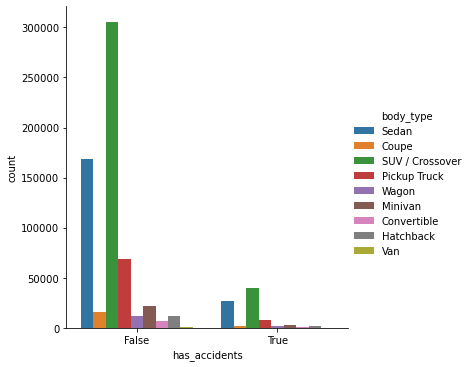

In [48]:
#Visulize the number of different type of cars that have accidents or not.
sns.catplot(x="has_accidents", kind="count",hue='body_type', data=df_final)

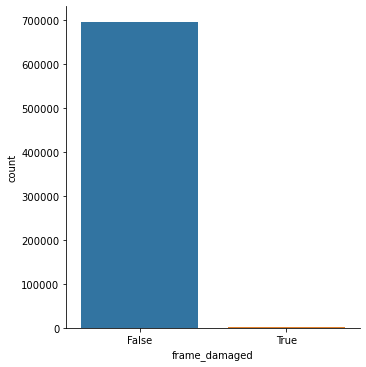

In [49]:
#Visualize the number of frame damaged cars
sns.catplot(x="frame_damaged", kind="count", data=df_final)

In [50]:
#check the count of frame_damaged cars
df_final['frame_damaged'].values.sum()

1587

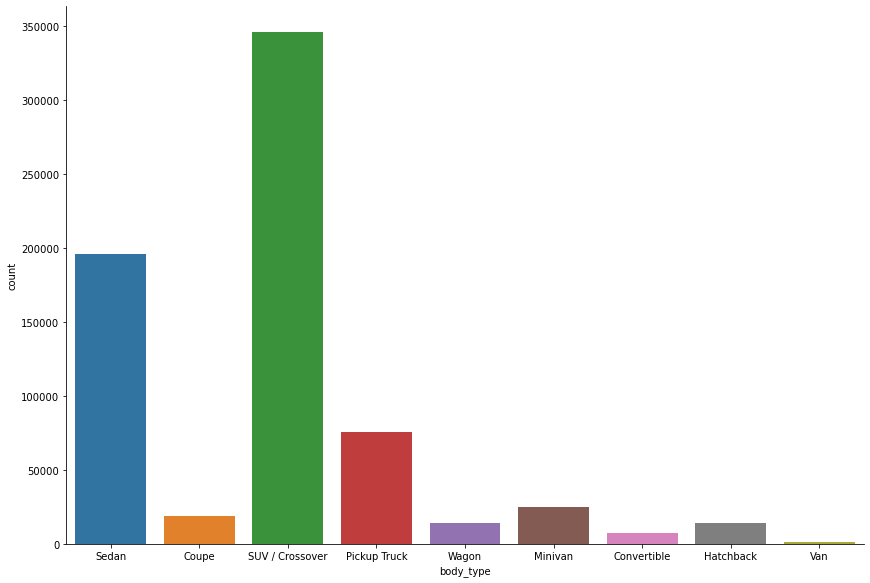

In [51]:
# check the number of different type of cars,it looks like SUV is the most popular car with almost 3500, Sedan is the 2nd most popular car.
sns.catplot(x="body_type", kind="count",data=df_final,height=8, aspect=1.5)

### Data normality check

In [75]:
##select all numberical data type from the final data
df_final_num=df_final.iloc[:, np.r_[1:4,6:9,10:18]]
print(df_final_num.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697989 entries, 38 to 3000039
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city_fuel_economy     697989 non-null  float64
 1   daysonmarket          697989 non-null  int64  
 2   engine_displacement   697989 non-null  float64
 3   height                697882 non-null  float64
 4   highway_fuel_economy  697989 non-null  float64
 5   horsepower            697989 non-null  float64
 6   length                697882 non-null  float64
 7   maximum_seating       697884 non-null  float64
 8   mileage               697989 non-null  float64
 9   owner_count           697989 non-null  float64
 10  price                 697989 non-null  float64
 11  seller_rating         697989 non-null  float64
 12  width                 697885 non-null  float64
 13  year                  697989 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 99.9 MB
Non

In [ ]:
##check all numerical type data's normality with pairplot
sns.pairplot(df_final_num)

#### From the histogram, we may easily see  city_fuel_economy,engine_displacement and highway_fuel_economy more normally distributed than other columns. As our sample size is large enough,we use Central Limit Theorem rule and assume they're approximately normal.

### Correlation check

### Visualize Attributes

### Explore Joint Attributes

When it comes to joint attributes, we would like to see if there's correlation between make name, price, wheel system and car body type.

First, we asked: 

*What's the most popular make name for used SUV, pickup Truck, sedan and convertibale?*
* "Ford" is the most popular make name for used SUV, Pickup Truck and Convertiable
* "Toyota" is the most popular make name for used Sedan

In [ ]:
df_carMake = pd.crosstab(df_cln_1.make_name, df_cln_1.body_type)
df_carMake.plot(figsize=(20,20), kind="bar", stacked = True)

Another question we asked was:

*What's the most popular make name for transmission (such as Automatic, CVT, Dual Clutch, or Manual)?*

* "Ford" is the most popular make name for 'Automatic' transmission
* "Nissan" is the most popular make name for 'CVT' transmission
* "Acura" is the most popular make name for 'Dual Clutch' transmission
* "Ford" is the most popular make name for 'Manual' transmission

In [ ]:
df_transmission = df_cln_1.groupby(['make_name', 'transmission'])['transmission'].count().unstack().fillna(0)
df_transmission.plot(figsize=(20,20), kind="bar", stacked = True)

We then asked:

*What's the highest amount of seating people are looking for when looking to buy a used car?*
* The most popular number of seats for used cars is 5 seats
* The second most popular number of seats for used car is 6 seats
* "Ford" is the most popular make name for both 5 seats used cars, and 6 seats used cars

In [ ]:
df_carSeats = pd.crosstab(df_cln_1.make_name, df_cln_1.maximum_seating)
df_carSeats.plot(figsize=(20,20), kind="bar", stacked = True)

Another interesting observation was:
*How is the data distributed by FWD (front weel drive)/RWD (rear wheel drive)?*
* Most of the used Sedans sold are FWD (front weel drive)
* Most of the used convertibles sold are RWD (real wheel drive)

In [ ]:
df_seadan_wheelType = pd.crosstab(df_cln_1.make_name, [df_cln_1.body_type , df_cln_1.wheel_system]).Sedan
df_seadan_wheelType.plot(figsize=(20,20), kind="bar", stacked = True)

In [ ]:
df_convertible_wheelType = pd.crosstab(df_cln_1.make_name, [df_cln_1.body_type , df_cln_1.wheel_system]).Convertible
df_convertible_wheelType.plot(figsize=(20,20), kind="bar", stacked = True)

### Explore Attributes and Class
we are using price (for regression), has_accidents(for logistic regression) and body_type(for multiclass classifications) as the response variables. In this section, we will try to find some interesting relations involving these features. 

'has-accidents' and 'is_new' are two booleans variables in our final dataset. We could have either or these these two values for the binary classification. But has_accidents feature is more balanced (false: 87% and true:13%) than that of is_new. That is the another driver, besides what is stated in the Business Understanding section, why we leaned on has_accidents for the binary response variable. However, we could have used is_new for the response variable. In that case, we should downscale or upscale, though the downscaling is preferred, training data, which would be an additional step. 

print('--attribute counts of is_new--')
print(df_final['is_new'].value_counts())

print('--attribute counts of has_accidents--')
print(df_final['has_accidents'].value_counts())

One may think the drivers of Sendan, Minivan or wagon may be more cautious that those who drive SUV or Pickup Truck. But at least based on used car market as presented in this visual, there is not much difference in the driving behavior amoung drives of different body types. However, the drivers of coupe and convertible exhibit restriant while on the road because the damage of their vehicle would cost them dearly.

In [ ]:
Price_bodytype_accidents = sns.barplot(x="body_type", y="price", hue = "has_accidents",data=df_final)
Price_bodytype_accidents.set_xticklabels(Price_bodytype_accidents.get_xticklabels(), rotation=90)

Coupe, SUV/Crossover, Convertible and Sedan have many outliers, whereas Wagon, Minivan and Vad do not have any outlier. In median used car price of 9 body types are with a close band. 

In [ ]:
Price_bodytype = sns.boxplot(x="body_type", y="price", data=df_final)
Price_bodytype.set_xticklabels(Price_bodytype.get_xticklabels(), rotation=90)

Sedan, SUV/Crossover, Pickup Truck stay in the market much loger than Coupe, Wagon and Hackback do. It is surprise to see that Coupe, though it is an expensive category car, sells faster Sedan, which we believe a common people's car. Most likely supply demand or mispricing is causing this anamoly. 

In [ ]:
plot = sns.catplot(x="body_type", y="daysonmarket", data=df_final)
for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

The lower the mileage, the higher the price, and that goes with the general notion. However, the relation breaks when the mileage goes beyond 50k as the price does not vary much from that point. 

In [ ]:
plt2 = sns.scatterplot(data=df_final, x="mileage", y="price", palette="deep")

We may think that the used cars having accidents will stay longer in the market, but that is not the case with an exception of Van. 

In [ ]:
Plt3 = sns.barplot(x="body_type", y="daysonmarket", hue = "has_accidents", palette="deep",data=df_final)
Plt3.set_xticklabels(Plt3.get_xticklabels(), rotation=90)

### New Features

We further group numerical predictors, including "price", to help us to gain more insight. 

This new feature is created using the attribute 'price'. 
We divide price into different price groups as following:

* "<5000"          : price < 5000
* "5000-10000"     : 5000 <= price <= 10000
* "10000-15000"    : 10000 < price <= 15000
* "15000-20000"    : 15000 < price <= 20000
* "20000-25000"    : 20000 < price <= 25000
* "25000 and over" : price > 25000

Obervations after we had used the new price group for data analysing:
* Over 65% of customers spent 25000 and more when buying a used Pickup truck
* Over 50% of customers spent over 20000 for a used SUV
* Over 50% of customers spent between 10000-20000 when buying a used sedan

In [ ]:
price_group = []
for price in df_final["price"]:
    if price < 5000:
        price_group.append("<5000")
    elif 5000 <= price <= 10000:
        price_group.append("5000-10000")
    elif 10000 < price <= 15000:
        price_group.append("10000-15000")
    elif 15000 < price <= 20000:
        price_group.append("15000-20000")
    elif 20000 < price <= 25000:
        price_group.append("20000-25000")
    else:
        price_group.append("25000 and over")

In [ ]:
new_df_price = df_final.copy()
new_df_price["price_group"] = price_group
del new_df_price["price"]
new_df_price.head(5)

In [ ]:
sns.catplot(x="price_group", y= "body_type", kind="bar", data=new_df_price)

In [ ]:
df_price = pd.crosstab(new_df_price.body_type, new_df_price.price_group)
df_price.plot(figsize=(20,20), kind="bar", stacked = True)

### Exceptional Work

In this section, we will use *one hot encoding* to encode the data and do a logistical regression on the data set

In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

First, we encode the categorical features as numbers

In [ ]:
def number_encode_features(df_final):
    result = df_final.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

Below shows a snap shot of what the final data looks like after categorical data has been encoded.
You can see the body type is in a numerical representation, instead of a string (object) type, before being encoded.

In [ ]:
encoded_data.tail(5)

As indicated in the heatmap in the sample statistics (above) section, we want to further explore the strong correlation between "price" and "body_type".

In [ ]:
encoded_data, encoders = number_encode_features(df_final)
new_series = encoded_data["body_type"]

Here, we are comparing correlation between "body_type" and the rest of the attributes by spliting and scaling the data.

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("body_type")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

Below, we ran it using "logistic regression"

In [ ]:
cls = linear_model.LogisticRegression()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [ ]:
print (accuracy_score(y_test, y_pred))

Below are a short summary of the corrleation between attribuates and body_type:

In [ ]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print (coefs.sort_values(ascending = False))